In [1]:
from datasets import load_dataset, DatasetDict, Dataset

c:\Users\Louis\anaconda3\envs\contest2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
origdat = load_dataset('csv', data_files={
    'train': "C:/Users/Louis/OneDrive/Documents/Oxford/Maths/Dissertation/train.csv",
    'test': "C:/Users/Louis/OneDrive/Documents/Oxford/Maths/Dissertation/valid.csv"
    }
)


Using custom data configuration default-d63da264504a44e4
Found cached dataset csv (C:/Users/Louis/.cache/huggingface/datasets/csv/default-d63da264504a44e4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 2/2 [00:00<00:00, 28.65it/s]


In [3]:
origdat

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'triage-category'],
        num_rows: 9559
    })
    test: Dataset({
        features: ['text', 'label', 'triage-category'],
        num_rows: 3114
    })
})

In [4]:
import pandas as pd
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_colwidth', 80)

origdat.set_format(type="pandas")
df = origdat["train"][:]
dfval = origdat["test"][:]
df.head()

,text,label,triage-category
0,: : : Sex: F Service: CARDIOTHORACIC Allergies: Patient recorded as having N...,4240,Cardiology
1,": : : Sex: F Service: NEONATOLOGY HISTORY: week gestation age female, admitt...",V3001,Obstetrics
2,: : : Sex: M Service: CARDIOTHORACIC Allergies: Patient recorded as having N...,41041,Cardiology
3,: : : Sex: F Service: MEDICINE Allergies: Penicillins / Ativan / Metformin :...,51881,Respiratory
4,: : : Sex: M Service: ADMISSION DIAGNOSIS: . Shortness of breath and chest t...,41401,Cardiology


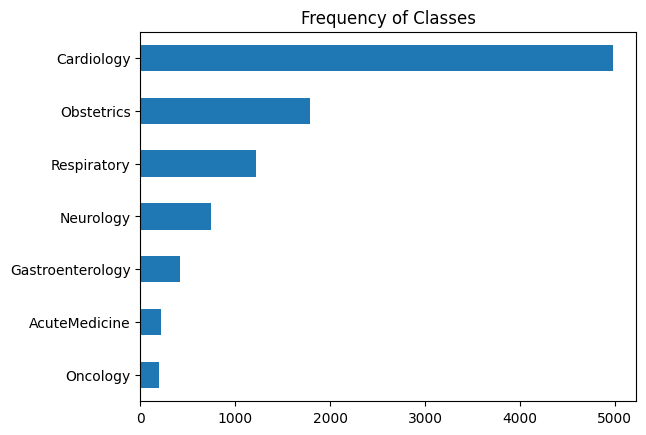

In [5]:
import matplotlib.pyplot as plt

df["triage-category"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

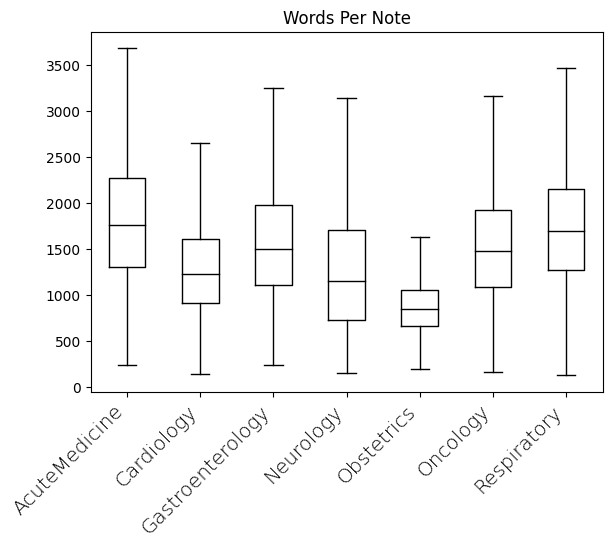

In [6]:
df["Words Per Note"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Note", by="triage-category", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

In [7]:
def labelint(row):
    if row == "AcuteMedicine":
        return 0
    if row == "Cardiology":
        return 1
    if row == "Gastroenterology":
        return 2
    if row == "Neurology":
        return 3
    if row == "Obstetrics":
        return 4
    if row == "Oncology":
        return 5
    if row == "Respiratory":
        return 6

df["class"] = df["triage-category"].apply(labelint)
dfval["class"] = dfval["triage-category"].apply(labelint)
df.head()

,text,label,triage-category,Words Per Note,class
0,: : : Sex: F Service: CARDIOTHORACIC Allergies: Patient recorded as having N...,4240,Cardiology,1525,1
1,": : : Sex: F Service: NEONATOLOGY HISTORY: week gestation age female, admitt...",V3001,Obstetrics,907,4
2,: : : Sex: M Service: CARDIOTHORACIC Allergies: Patient recorded as having N...,41041,Cardiology,2092,1
3,: : : Sex: F Service: MEDICINE Allergies: Penicillins / Ativan / Metformin :...,51881,Respiratory,1552,6
4,: : : Sex: M Service: ADMISSION DIAGNOSIS: . Shortness of breath and chest t...,41401,Cardiology,913,1


In [8]:
trdf = df.drop(columns=["label", "triage-category", "Words Per Note"])
trval = dfval.drop(columns=["label", "triage-category"])
trdf.head()

,text,class
0,: : : Sex: F Service: CARDIOTHORACIC Allergies: Patient recorded as having N...,1
1,": : : Sex: F Service: NEONATOLOGY HISTORY: week gestation age female, admitt...",4
2,: : : Sex: M Service: CARDIOTHORACIC Allergies: Patient recorded as having N...,1
3,: : : Sex: F Service: MEDICINE Allergies: Penicillins / Ativan / Metformin :...,6
4,: : : Sex: M Service: ADMISSION DIAGNOSIS: . Shortness of breath and chest t...,1


In [9]:
x = trdf.rename(columns={"class": "label"})
y = trval.rename(columns={"class": "label"})

In [10]:
x.head()

,text,label
0,: : : Sex: F Service: CARDIOTHORACIC Allergies: Patient recorded as having N...,1
1,": : : Sex: F Service: NEONATOLOGY HISTORY: week gestation age female, admitt...",4
2,: : : Sex: M Service: CARDIOTHORACIC Allergies: Patient recorded as having N...,1
3,: : : Sex: F Service: MEDICINE Allergies: Penicillins / Ativan / Metformin :...,6
4,: : : Sex: M Service: ADMISSION DIAGNOSIS: . Shortness of breath and chest t...,1


In [11]:
mimic = DatasetDict({
    "train" : Dataset.from_pandas(x).class_encode_column("label"), 
    "validation" : Dataset.from_pandas(y).class_encode_column("label") 
})

Casting to class labels: 100%|██████████| 4/4 [00:00<00:00, 363.32ba/s]


In [12]:
mimic

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9559
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 3114
    })
})

In [13]:
from transformers import AutoTokenizer

model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

c:\Users\Louis\anaconda3\envs\contest2\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Louis\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [14]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True) #max_length=?

In [15]:
mim_enc = mimic.map(tokenize, batched=True, batch_size=None)

100%|██████████| 1/1 [00:02<00:00,  2.39s/ba]


In [16]:
print(mim_enc["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [17]:
import torch

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
from transformers import AutoModelForSequenceClassification

num_labels = 7
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [21]:
from transformers import Trainer, TrainingArguments

batch_size = 2
logging_steps = len(mim_enc["train"]) // batch_size
#CHECK output_dir meaning, have I messed up?
model_name = f"{model_ckpt}-mimicfullclass"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [22]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=mim_enc["train"],
                  eval_dataset=mim_enc["validation"],
                  tokenizer=tokenizer)
trainer.train();

c:\Users\Louis\anaconda3\envs\contest2\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 50%|█████     | 4780/9560 [11:48<10:23,  7.67it/s]  

{'loss': 0.4788, 'learning_rate': 1.0002092050209206e-05, 'epoch': 1.0}


                                                   
 50%|█████     | 4781/9560 [12:44<22:45:58, 17.15s/it]

{'eval_loss': 0.3736928701400757, 'eval_accuracy': 0.9283879254977521, 'eval_f1': 0.9235552181680228, 'eval_runtime': 56.7269, 'eval_samples_per_second': 54.895, 'eval_steps_per_second': 27.447, 'epoch': 1.0}


100%|█████████▉| 9559/9560 [24:49<00:00,  6.64it/s]   

{'loss': 0.2727, 'learning_rate': 4.184100418410042e-09, 'epoch': 2.0}


                                                   
100%|██████████| 9560/9560 [25:50<00:00,  6.17it/s]

{'eval_loss': 0.31775736808776855, 'eval_accuracy': 0.9405908798972383, 'eval_f1': 0.9416942643120513, 'eval_runtime': 60.7828, 'eval_samples_per_second': 51.232, 'eval_steps_per_second': 25.616, 'epoch': 2.0}
{'train_runtime': 1550.1148, 'train_samples_per_second': 12.333, 'train_steps_per_second': 6.167, 'train_loss': 0.3756394936413934, 'epoch': 2.0}


In [23]:
preds_output = trainer.predict(mim_enc["validation"])

100%|██████████| 1557/1557 [00:59<00:00, 26.33it/s]


In [24]:
preds_output

PredictionOutput(predictions=array([[-1.5511229 ,  9.22006   , -1.3067886 , ..., -2.6835473 ,
        -3.2020864 , -0.960396  ],
       [-1.7350651 , -1.6780249 , -1.7415005 , ..., 10.70256   ,
        -1.4628329 , -1.8762994 ],
       [-1.6963128 , -1.6463583 , -1.6432256 , ..., 10.683848  ,
        -1.5161674 , -1.8694282 ],
       ...,
       [-1.7247945 , -1.679749  , -1.6320162 , ..., 10.695642  ,
        -1.4902272 , -1.9002601 ],
       [-0.9895866 ,  9.088728  , -1.2992535 , ..., -2.9126098 ,
        -3.1446724 , -1.0182472 ],
       [-1.6335225 ,  9.246397  , -1.4080789 , ..., -2.6341789 ,
        -3.0661142 , -0.96434724]], dtype=float32), label_ids=array([1, 4, 4, ..., 4, 1, 1], dtype=int64), metrics={'test_loss': 0.31775736808776855, 'test_accuracy': 0.9405908798972383, 'test_f1': 0.9416942643120513, 'test_runtime': 59.2756, 'test_samples_per_second': 52.534, 'test_steps_per_second': 26.267})

In [25]:
preds_output.metrics

{'test_loss': 0.31775736808776855,
 'test_accuracy': 0.9405908798972383,
 'test_f1': 0.9416942643120513,
 'test_runtime': 59.2756,
 'test_samples_per_second': 52.534,
 'test_steps_per_second': 26.267}

In [26]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [28]:
y_valid = np.array(mimic["validation"]["label"])

In [29]:
labels = mimic["train"].features["label"].names

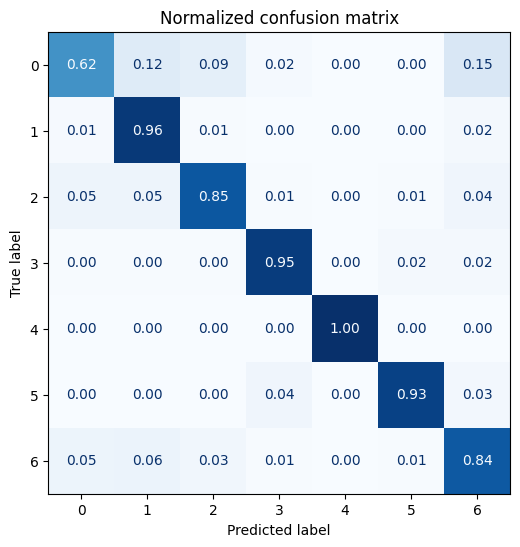

In [30]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [31]:
trainer.save_model("C:/Users/Louis/OneDrive/Documents/Oxford/Maths/Dissertation/Models/robertamulti1")